In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import itertools
import graphviz
import seaborn as sns

from time import time
from copy import deepcopy
from sklearn.preprocessing import normalize

### To do 

* Fix add_edge()

* Fixate parasite

* Correct probability of mutation

* Implement coevolution

* Imeplement analysis metrics

In [128]:
class Population:
    def __init__(self, population_size, verbose = 0):
        self.population_size = population_size
        self.hosts = [Host(verbose = verbose) for n in range(population_size)]
        
        self.current_generation = 0
        self.generations = [self.hosts]
        self.average_fitness = [] 
        
        self.verbose = verbose
    
    def selection(self, threshold=10e-4, p_mutation = 5e-3, selection_seed=np.random.randint(0,1000)):
        
        fitness_vector = np.zeros(self.population_size)
        
        for i,host in enumerate(self.hosts):
            host.evolve(parasite_seed=selection_seed)
            fitness_vector[i] = host.fitness_host
        
                                  
        print('Generation {}. Average fitness: {}. Best fitness: {}.'.format(self.current_generation, np.mean(fitness_vector), np.max(fitness_vector)))
        self.average_fitness.append(np.mean(fitness_vector))

        fitness_vector = np.array([x for x in fitness_vector if  x > threshold])
        cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))
        #print('Sampling: ',[i for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, self.population_size))])
        next_gen = [self.hosts[i].reproduce(p_mutation = p_mutation * (1000/self.population_size)) for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, self.population_size))]
        
        self.generations.append(next_gen)
        self.hosts = next_gen
        
        self.current_generation += 1

    
class Host:
    def __init__(self, verbose = 0):
        self.n_nodes = 6
        self.n_signalers = self.n_nodes - 2
        
        self.verbose = verbose
        
        self.network = nx.binomial_graph(directed=True, n=self.n_nodes,p=0.5)
        
        mapping = dict(list(zip(range(self.n_nodes), ['D']+list(range(self.n_nodes-2))+['E'])))
        
        self.network = nx.relabel_nodes(self.network, mapping)
                
        for i,node in enumerate(self.network.nodes):
            self.network.nodes[node]['active'] = 0.5
            self.network.nodes[node]['label'] = (['D']+(self.n_nodes-2)*['S']+['E'])[i]
    
        for u,v,e in self.network.edges(data=True):
            e['weight'] = np.random.uniform(-1,1)

        self.network.remove_edges_from([('E','D'),('D','E')])
        
        #to track back for reproduction
        self.architecture = deepcopy(self.network)
        
        self.infected = False
        
    
    
    def update(self):
        network_copy = deepcopy(self.network)

        for node in self.network.nodes:
            dP = 0
            for n in self.network.predecessors(n=node):
                weight = nx.get_edge_attributes(self.network,'weight')[(n,node)] 
                if weight > 0:
                    dP += (1-self.network.node[node]['active'])*weight*self.network.node[n]['active']
                elif weight < 0:
                    dP += self.network.node[node]['active']*weight*self.network.node[n]['active']
            
            if np.isnan(dP):
                print('NAN!')
                print(nx.get_edge_attributes(self.network,'weight'))
                print(nx.get_node_attributes(self.network,'active'))
            
            if network_copy.node[node]['active'] + dP > 1:
                network_copy.node[node]['active'] = 1
            elif network_copy.node[node]['active'] + dP < 0:
                network_copy.node[node]['active'] = 0
            else:
                network_copy.node[node]['active'] += dP
            
            #network_copy.node[node]['active'] = min(1, network_copy.node[node]['active'] + dP) 

        self.network = network_copy
    
    def infect(self, r=0.8, v=5, seed = np.random.randint(0,1000), coevolve=False):
        #self.v = v
        self.network.add_node(node_for_adding='P', active=0.5, label='P')
        self.network.add_weighted_edges_from([('P','D',1.0), ('E','P',-1.0), ('P','P',r)])
        
        self.network.nodes['P']['area'] = 0.5
        self.network.nodes['P']['v'] = v
        
        
        if coevolve:
            np.random.seed(seed=seed)

            signalers = [n for n in self.architecture.nodes if n not in ['D','E']]

            self.network.nodes['P']['target'] = np.random.choice(signalers)

            self.network.nodes['P']['mode'] = np.random.choice(['upreg','downreg'])




            target = self.network.nodes['P']['target']

            if self.network.nodes['P']['mode'] == 'downreg':
                self.network.remove_node(target)
            elif self.network.nodes['P']['mode'] == 'upreg':
                self.network.nodes[target]['active'] = 1
                self.network.remove_edges_from([e for e in self.network.edges if e[1] == target])

                for e in [e for e in self.network.edges if e[0] == target]:
                    if self.network.edges[e]['weight'] > 0:
                        self.network.edges[e]['weight'] = min(1.0, 2*self.network.edges[e]['weight'])
                    else:
                        self.network.edges[e]['weight'] = max(-1.0, 2*self.network.edges[e]['weight'])
    
    
        if self.verbose >= 1:
            print(self.network.nodes['P'])
        
    def evolve(self, parasite_seed=np.random.randint(0,1000)):
        for _ in range(600):
            self.update()       
        
        active_pre = self.network.nodes['E']['active']
        
        self.infect(seed = parasite_seed)
        
        for _ in range(600):
            self.update()
            self.network.nodes['P']['area'] += self.network.nodes['P']['active']
        
        #round or not round?
        self.network.nodes['P']['area'] = round(self.network.nodes['P']['area'] / 600,4)
        
        
        area = self.network.nodes['P']['area']
        active_post = self.network.nodes['E']['active']
        
        
        v = self.network.nodes['P']['v']
        
        if self.verbose >= 2:
            print('Active_pre: ', active_pre)
            print('Active_post: ', active_post)
            print('Area: ', area)
        
        self.fitness_host = np.exp(-1*(active_pre + v*area + active_post))
        self.fitness_parasite = np.exp(-1*(2+v)*(1-area))
        
    
    
    def mutate(self, p_mutation = 5e-3):
        """
        25% addition of new allowed edge
        25% deletion of existing edge
        30% alteration of existing edge **
        10% duplication of a protein and all its edges
        10% deletion of a protein and all its edges
        """
        
        self.addible_signalers = 8 - self.n_signalers
        
        signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        for signaler in signalers:
            
            if np.random.random() < p_mutation:
        
                mutation_type = np.random.random()

                if mutation_type < 0.25:
                    #add allowed edge
                    self.new_edge(signaler)

                elif mutation_type < 0.5:
                    #remove edge
                    self.remove_edge(signaler)

                elif mutation_type < 0.8:
                    #alter edge
                    self.alter_edge(signaler)

                elif mutation_type < 0.9:
                    #duplicate signaler
                    self.duplicate_signaler(signaler) #to do: find out how to increase n_signalers
                else:
                    #delete signaler
                    self.remove_signaler(signaler) #to do: find out how to decrease n_signalers
        
        #return new_architecture
    
    
    def new_edge(self, signaler):
        
        #new_architecture = self.architecture
        
        #signalers = [n for n in self.new_architecture.nodes if n not in ['D','E']]
        
        
        potential_edges = list(set([p for p in itertools.permutations(self.new_architecture.nodes, 2) if p[0] == signaler or p[1] == signaler]) - \
                                set([(u,v) for u,v,d in self.new_architecture.edges(data=True) if u == signaler or v == signaler]))
        
        
        if len(potential_edges) == 0:
            if self.verbose >= 1:
                print('No new edges can be added to signaler', signaler)
            
            #end function if no edge can be added before it raises error
            return
        
        new_edge = potential_edges[np.random.choice(len(potential_edges))]
        
        
        
        
#         edge_already_exists = True
        
#         # to do: optimize!!!!!!!!! search directly from available edges
#         while edge_already_exists:

#             node1 = np.random.choice(signalers)
            
#             node2 = np.random.choice(new_architecture.nodes)

#             potential_edge = sorted((node1,node2), key=lambda k: np.random.random())

#             for i,node in enumerate(potential_edge):
#                 try:
#                     potential_edge[i] = int(node)
#                 except:
#                     pass


#             if potential_edge[0] == potential_edge[1]:
#                 continue

#             if potential_edge not in new_architecture.edges:
#                 edge_already_exists = False

        new_weight = np.random.uniform(-1.0,1.0)
        
        self.new_architecture.add_weighted_edges_from([(new_edge[0], new_edge[1], new_weight)])
        
        if self.verbose >= 1:
            print('New edge: ', potential_edge,' Weight: ', new_weight)
            
        #return new_architecture
    
    def remove_edge(self, signaler):
        
        #new_architecture = self.architecture
        
        signaler_edges = [(u,v) for u,v,d in self.new_architecture.edges(data=True) if u == signaler or v == signaler]
        
        if len(signaler_edges) == 0:
            if self.verbose >= 1:
                print('Warning: cannot remove more edges from mutated node')
            return #new_architecture
        
        edge_index = np.random.randint(0,len(signaler_edges))
        edge_to_remove = signaler_edges[edge_index]

        self.new_architecture.remove_edge(edge_to_remove[0], edge_to_remove[1])
        
        if self.verbose >= 1:
            print('Edge removed: ',edge_to_remove)
        
        #return new_architecture

    def alter_edge(self, signaler):
        
        #new_architecture = self.architecture
        
        signaler_edges = [(u,v) for u,v,d in self.new_architecture.edges(data=True) if u == signaler or v == signaler]
        
        if len(signaler_edges) == 0:
            if self.verbose >= 1:
                print('Warning: Mutated node has no edges to alter')
            return
        
        edge_index = np.random.randint(0,len(signaler_edges))
        edge_to_alter = signaler_edges[edge_index]
        self.new_architecture.edges[edge_to_alter]['weight'] = np.random.uniform(-1.0,1.0)


        
        
#         try:
#             edge_index = np.random.randint(0,len(new_architecture.edges()))
#             edge_to_alter = list(new_architecture.edges())[edge_index]
#             new_architecture.edges[edge_to_alter]['weight'] = np.random.uniform(-1.0,1.0)

        if self.verbose >= 1:
            print('New weight of ', edge_to_alter, ': ', self.new_architecture.edges[edge_to_alter]['weight'])

        #except:
        #    pass
        
        
        #return new_architecture
    
    
    def duplicate_signaler(self, signaler):
        
        #new_architecture = self.architecture

        if self.addible_signalers == 0:
            if self.verbose >= 1:
                print('Warning: cannot duplicate signaler')
            return
        
        
        
        
#         if len(signalers) >= 8:
#             if verbose >= 1:
#                 print('Warning: cannot add more signalers')
#             return new_architecture

        #signaler_index = signaler
        
        if self.verbose >= 1:
            print('Signaler to undergo duplication: ', signaler)
            
        signalers = [n for n in self.new_architecture.nodes if n not in ['D','E']]

        new_out_edges =[(max(signalers)+1,v,d['weight']) for u,v,d in self.new_architecture.edges(data=True) if u == signaler]
        new_in_edges = [(u,max(signalers)+1,d['weight']) for u,v,d in self.new_architecture.edges(data=True) if v == signaler]

        self.new_architecture.add_node(max(signalers)+1)
        self.new_architecture.add_weighted_edges_from(new_out_edges)
        self.new_architecture.add_weighted_edges_from(new_in_edges)

        self.new_architecture.nodes[max(signalers)+1]['label'] = 'S'
        self.new_architecture.nodes[max(signalers)+1]['active'] = 0.5
        
        
        self.addible_signalers -= 1
        #return new_architecture
        
    def remove_signaler(self, signaler):
        
        #new_architecture = self.architecture
        
        #signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
        
        if self.addible_signalers == 7:
            if self.verbose >= 1:
                print('Warning: cannot remove more signalers')
            return# new_architecture
        
        #node_to_remove = signaler

        if self.verbose >= 1:
            print('Signaler to remove: ',signaler)
        
        self.new_architecture.remove_node(signaler)
        
        self.addible_signalers += 1
        
        #return new_architecture
        
    def reproduce(self, p_mutation=5e-3):
        
        self.new_architecture = self.architecture
        
        #total_p_mutation = p_mutation * len([n for n in self.architecture.nodes if n not in ['D','E']])
        
#         if np.random.random() < total_p_mutation:
#             new_architecture = self.mutate(verbose=verbose)
#             new_n_signalers = len([n for n in new_architecture.nodes if n not in ['D','E']]) #might fail!
            
        self.mutate(p_mutation)
        
        return HostChild(self.new_architecture)
        

        if self.verbose >= 1:
            print('No mutations occurred')
#            return HostChild(self.architecture, self.n_signalers)
        

            
        
    def visualize(self, ax=None):
        
        if ax==None:
            fig, ax = plt.subplots(1)
        
        
        edges,weights = zip(*nx.get_edge_attributes(self.network,'weight').items())

        activating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]
        positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w > 0]

        deactivating = [e for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.network,'weight').items() if w < 0]
        
        active_ratios = list(nx.get_node_attributes(self.network,'active').values())
        #print(active_ratios)
        
        pos = nx.shell_layout(self.network)

        graph_nodes = nx.draw_networkx_nodes(self.network, node_size=300, pos=pos, alpha=1, ax=ax,
                               node_color= [a for a in active_ratios],
                                            cmap='Greens', vmin=0, vmax=1.5)  

        graph_act_edges =nx.draw_networkx_edges(self.network, edgelist=activating, ax=ax,
                               pos=pos, width=[5*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                                alpha=1)

        graph_deact_edges = nx.draw_networkx_edges(self.network, edgelist=deactivating, ax=ax,
                               pos=pos, width=[5*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                                alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))
        
            
        labels = nx.get_node_attributes(self.network, 'label')

        nx.draw_networkx_labels(self.network, pos=pos, ax=ax,
                               labels = labels)
        nx.draw_networkx_edge_labels(self.network, font_color='#0055FF', label_pos=0.3, ax=ax,
                                    pos=pos, edge_labels=dict(zip(activating,positive_weights)))
        nx.draw_networkx_edge_labels(self.network, font_color='#FF0000', label_pos = 0.3, ax=ax,
                                     pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))
        
        graph_nodes.set_edgecolor('k')

        try:
            graph_edges = graph_act_edges+graph_deact_edges
        except:
            
            if type(graph_act_edges) == 'list':
                if self.verbose >= 2:
                    print('Only activating edges are left')
                graph_edges = [graph_act_edges]
            elif type(graph_deact_edges) == 'list':
                if self.verbose >= 2:
                    print('Only deactivating edges are left')
                graph_edges = [graph_deact_edges]
                
        
        for e in graph_edges:
            e.set_alpha(0.5)
        
        ax.axis('off')
        
        plt.show()
        
        
    def visualize_architecture(self):
        edges,weights = zip(*nx.get_edge_attributes(self.architecture,'weight').items())

        activating = [e for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w > 0]
        positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w > 0]

        deactivating = [e for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w < 0]
        negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(self.architecture,'weight').items() if w < 0]
        
        active_ratios = list(nx.get_node_attributes(self.architecture,'active').values())
        #print(active_ratios)
        
        pos = nx.shell_layout(self.architecture)

        graph_nodes = nx.draw_networkx_nodes(self.architecture, node_size=300, pos=pos, alpha=1, 
                               node_color= [a for a in active_ratios],
                                            cmap='Greens', vmin=0, vmax=1.5)  

        graph_act_edges =nx.draw_networkx_edges(self.architecture, edgelist=activating,
                               pos=pos, width=[5*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                                alpha=1)

        graph_deact_edges = nx.draw_networkx_edges(self.architecture, edgelist=deactivating,
                               pos=pos, width=[5*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                                alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))
        
            
        labels = nx.get_node_attributes(self.architecture, 'label')

        nx.draw_networkx_labels(self.architecture, pos=pos, 
                               labels = labels)
        nx.draw_networkx_edge_labels(self.architecture, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
        nx.draw_networkx_edge_labels(self.architecture, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))
        
        graph_nodes.set_edgecolor('k')
        
        try:
            graph_edges = graph_act_edges+graph_deact_edges
        except:
            
            if type(graph_act_edges) == 'list':
                if self.verbose >= 2:
                    print('Only activating edges are left')
                graph_edges = [graph_act_edges]
            elif type(graph_deact_edges) == 'list':
                if self.verbose >= 2:
                    print('Only deactivating edges are left')
                graph_edges = [graph_deact_edges]
                
        
        for e in graph_edges:
            e.set_alpha(0.5)

        #plt.show()
        
    
class HostChild(Host):
    def __init__(self, new_architecture):
        super().__init__()

        self.network = new_architecture
        self.architecture = new_architecture
        self.n_signalers = len(self.architecture) - 2

In [129]:
host = Host()

In [7]:
population1 = Population(100)

for _ in range(20):
    population1.selection(threshold=0.0001)
    #print('Generation {} complete.'.format(_))

plt.plot(population1.average_fitness)

plt.show()


Generation 0. Average fitness: 0.14673378746266952. Best fitness: 0.19761652895632617.
Generation 1. Average fitness: 0.1511270823244924. Best fitness: 0.21431393993183637.
Generation 2. Average fitness: 0.1517109511357757. Best fitness: 0.1976415607792834.
Generation 3. Average fitness: 0.14836439781258218. Best fitness: 0.1976415607792834.
Generation 4. Average fitness: 0.14873439850012424. Best fitness: 0.1976415607792834.
Generation 5. Average fitness: 0.14162047523967375. Best fitness: 0.18858383316149674.
Generation 6. Average fitness: 0.14142213512291957. Best fitness: 0.18858383316149674.
Generation 7. Average fitness: 0.14359032126158036. Best fitness: 0.18858383316149674.
Generation 8. Average fitness: 0.1432287395229719. Best fitness: 0.18858383316149674.
Generation 9. Average fitness: 0.14193298819795439. Best fitness: 0.18816288846311016.
Generation 10. Average fitness: 0.14486126022356907. Best fitness: 0.18816288846311016.
Generation 11. Average fitness: 0.15820880474870

KeyboardInterrupt: 

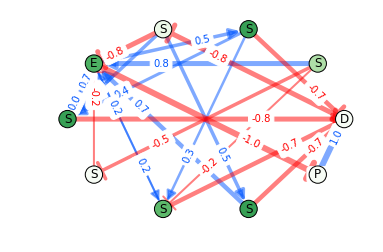

0.19301459641847935


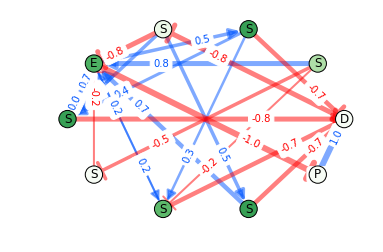

0.19301459641847935


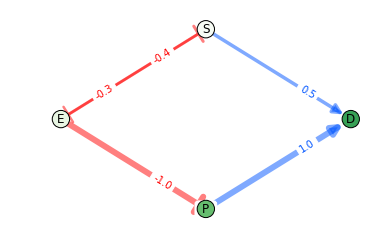

0.14653704598562206


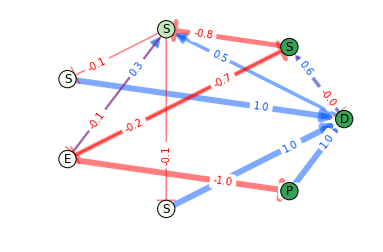

0.1353352832366127


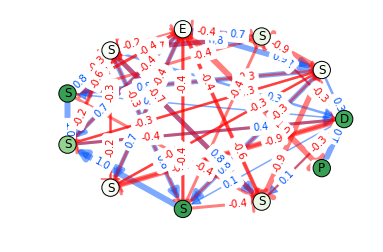

0.1353352832366127


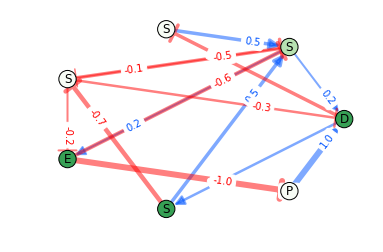

0.1347950233437983


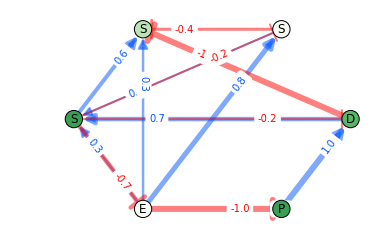

0.1353352832366127


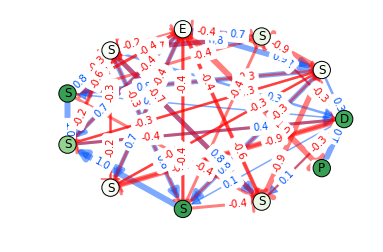

0.1353352832366127


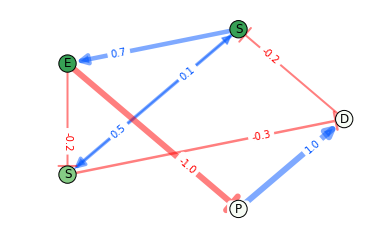

0.1347950233437982


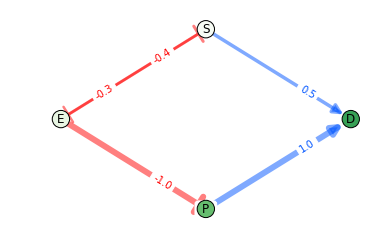

0.14653704598562206


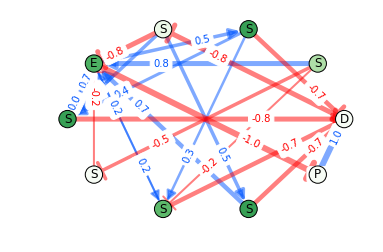

0.19301459641847935


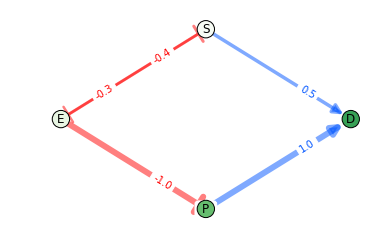

0.14653704598562206


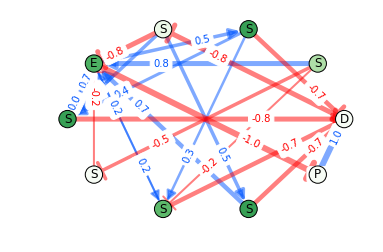

0.19301459641847935


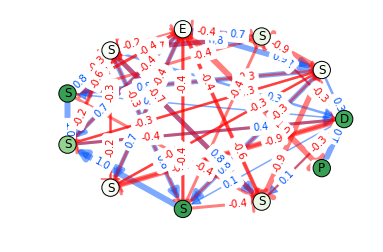

0.1353352832366127


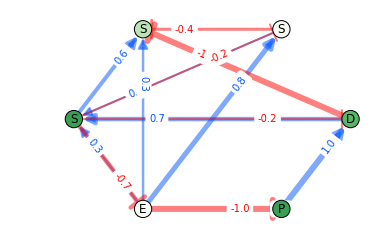

0.1353352832366127


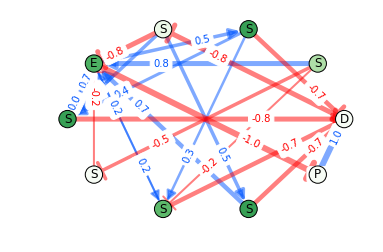

0.19301459641847935


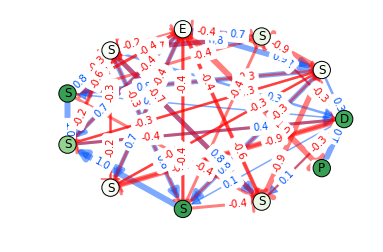

0.1353352832366127


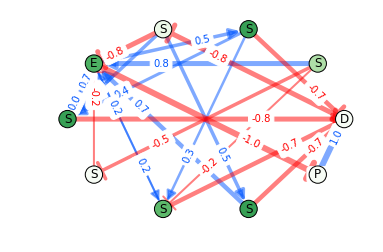

0.19301459641847935


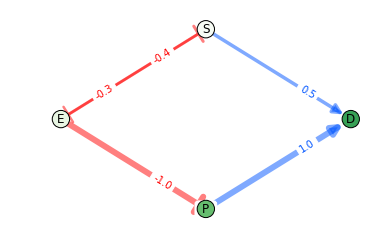

0.14653704598562206


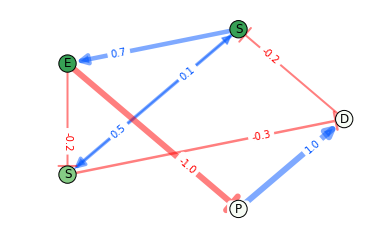

0.1347950233437982


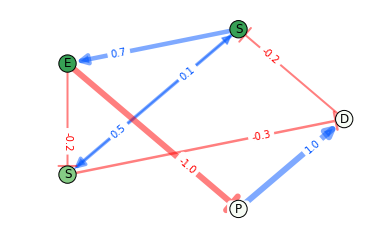

0.1347950233437982


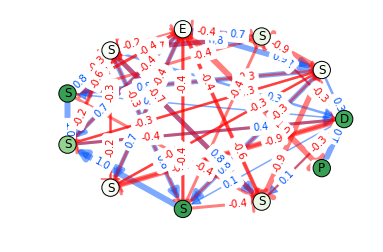

0.1353352832366127


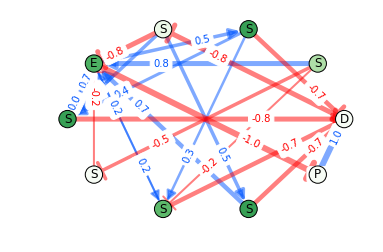

0.19301459641847935


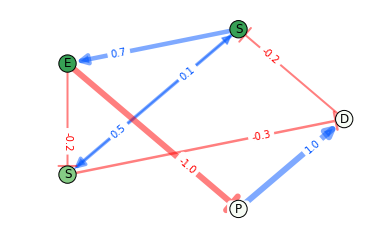

0.1347950233437982


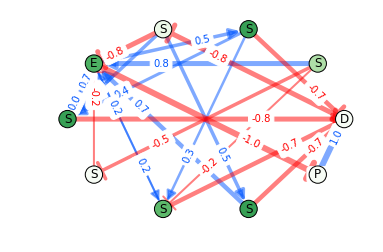

0.19301459641847935


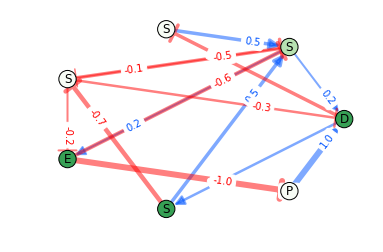

0.1347950233437983


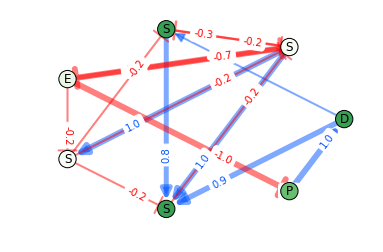

0.1467348661800212


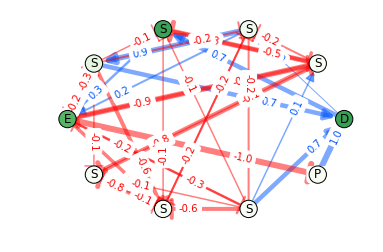

0.17621621744825947


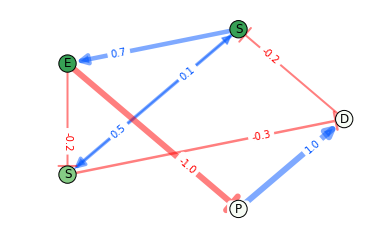

0.1347950233437982


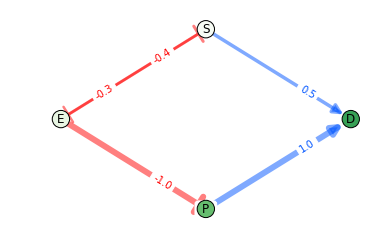

0.14653704598562206


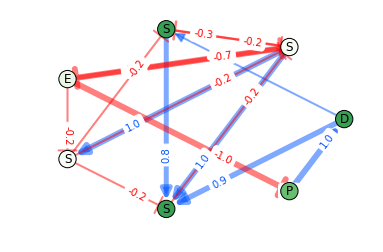

0.1467348661800212


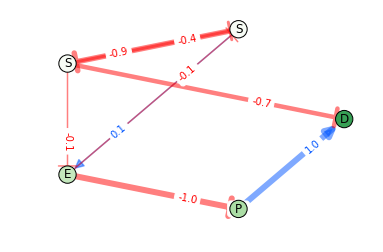

0.16742021554301287


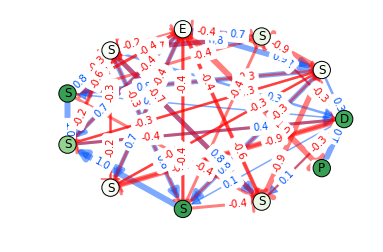

0.1353352832366127


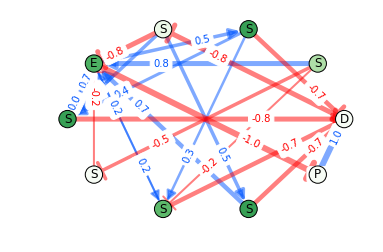

0.19301459641847935


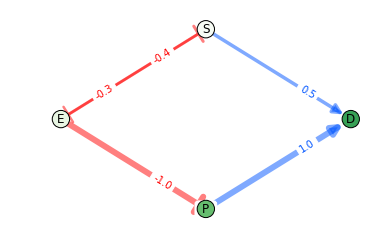

0.14653704598562206


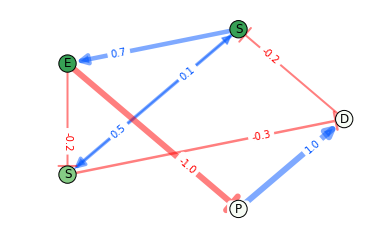

0.1347950233437982


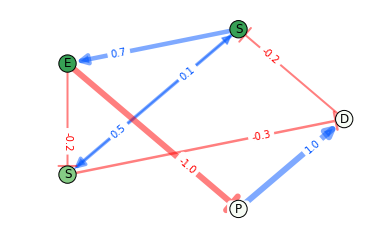

0.1347950233437982


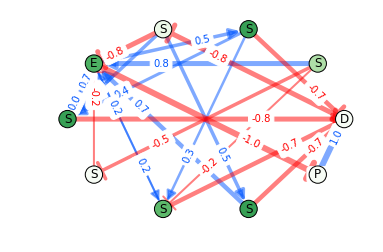

0.19301459641847935


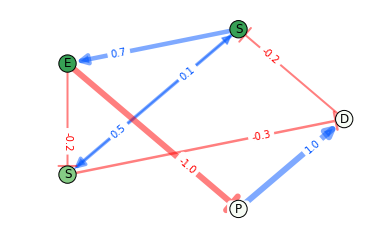

0.1347950233437982


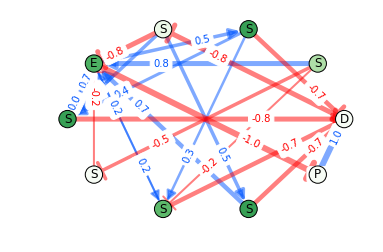

0.19301459641847935


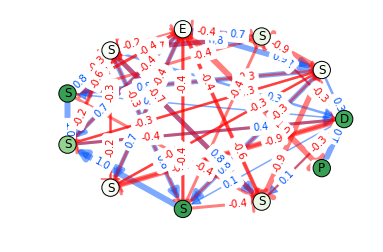

0.1353352832366127


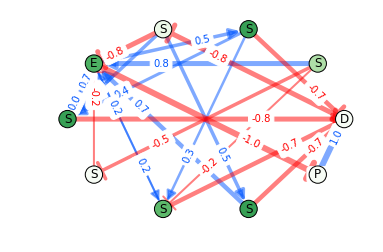

0.19301459641847935


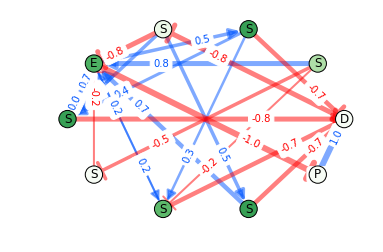

0.19301459641847935


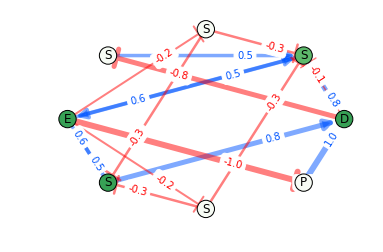

0.1347950233437982


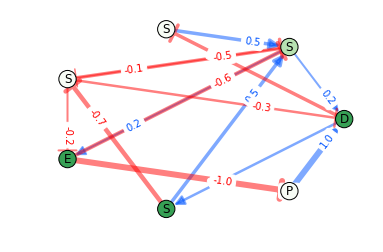

0.1347950233437983


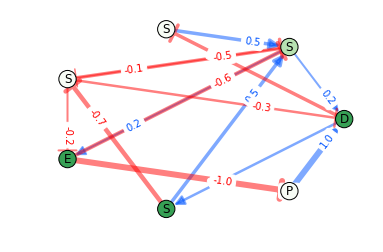

0.1347950233437983


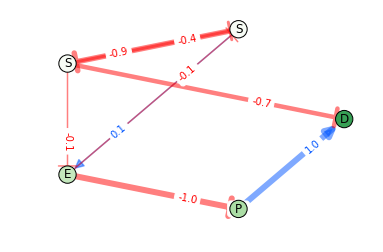

0.16742021554301287


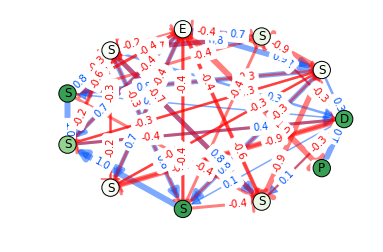

0.1353352832366127


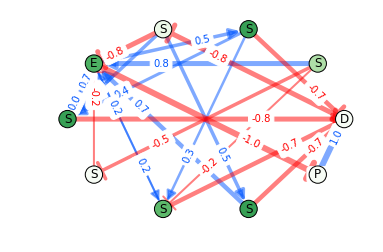

0.19301459641847935


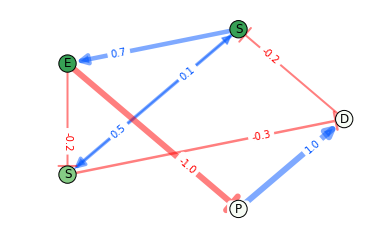

0.1347950233437982


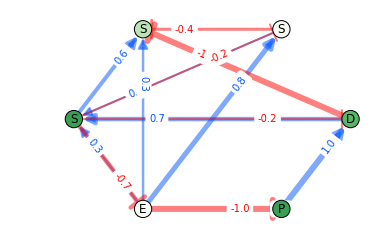

0.1353352832366127


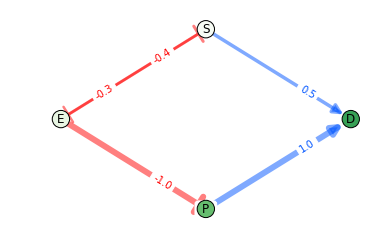

0.14653704598562206


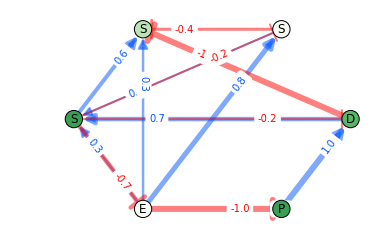

0.1353352832366127


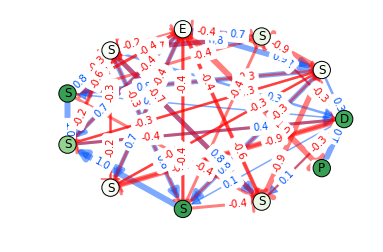

0.1353352832366127


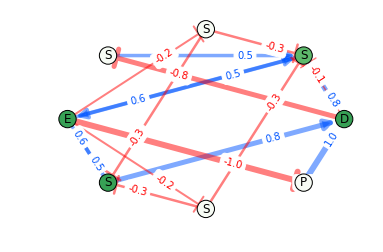

0.1347950233437982


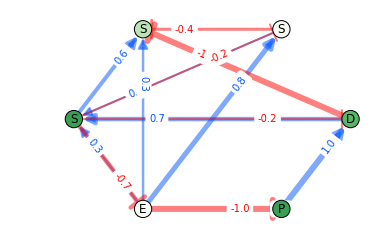

0.1353352832366127


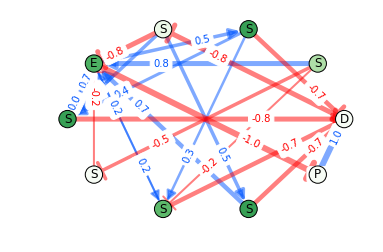

0.19301459641847935


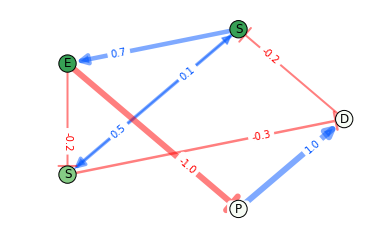

0.1347950233437982


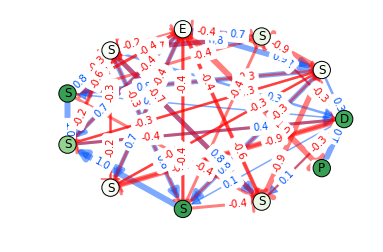

0.1353352832366127


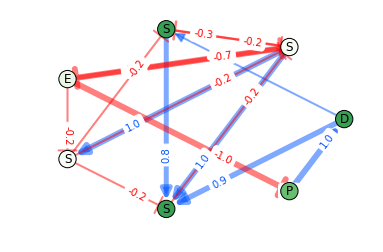

0.1467348661800212


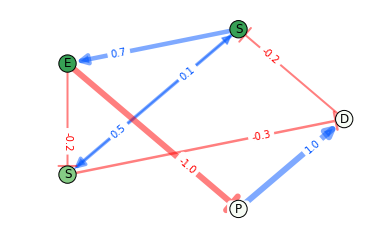

0.1347950233437982


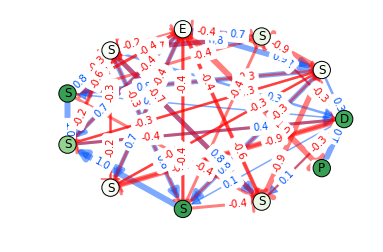

0.1353352832366127


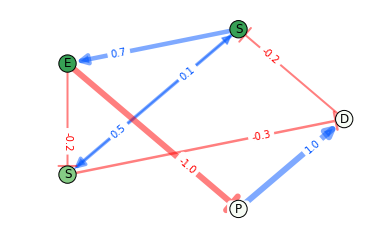

0.1347950233437982


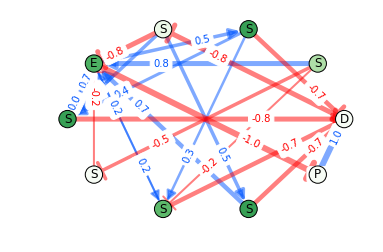

0.19301459641847935


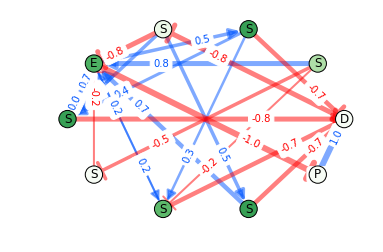

0.19301459641847935


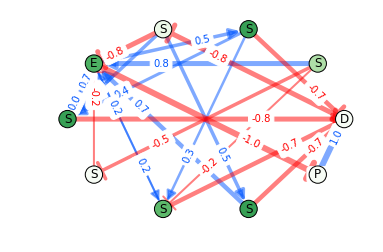

0.19301459641847935


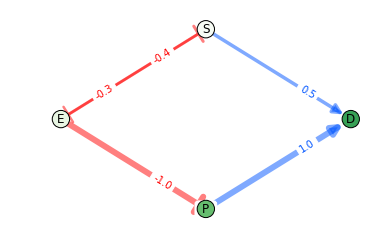

0.14653704598562206


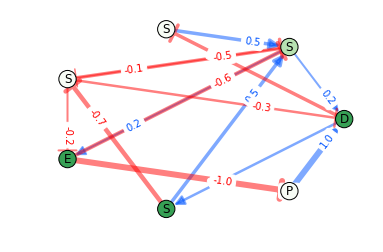

0.1347950233437983


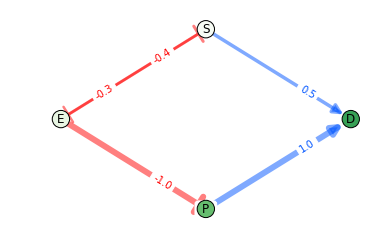

0.14653704598562206


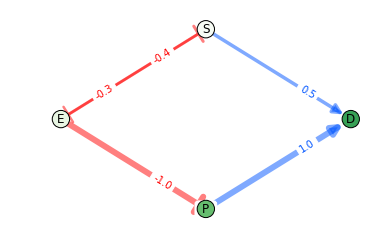

0.14653704598562206


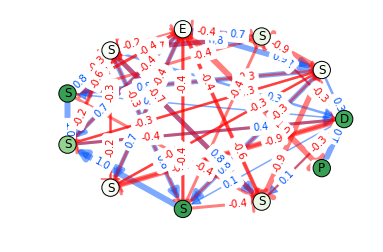

0.1353352832366127


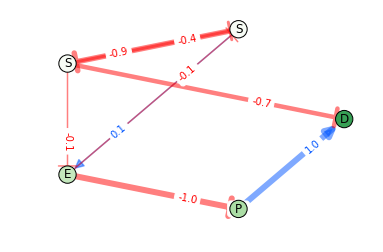

0.16742021554301287


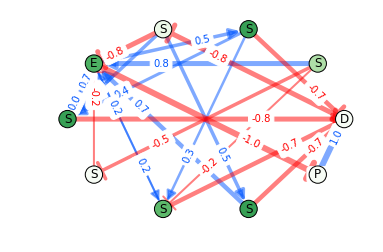

0.19301459641847935


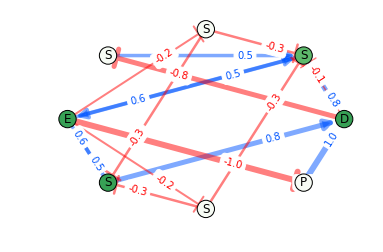

0.1347950233437982


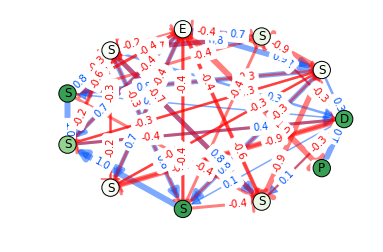

0.1353352832366127


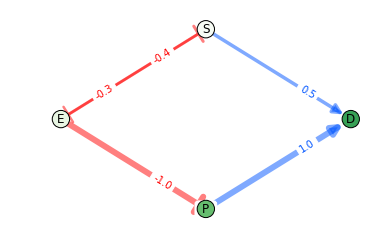

0.14653704598562206


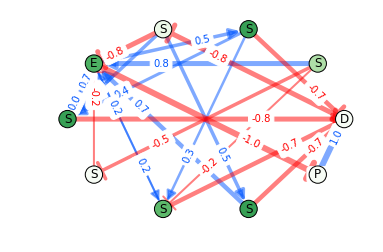

0.19301459641847935


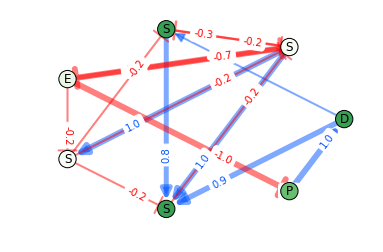

0.1467348661800212


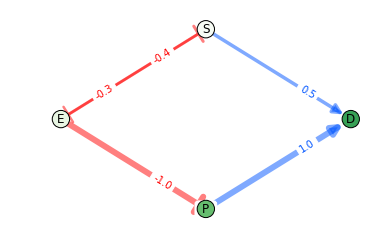

0.14653704598562206


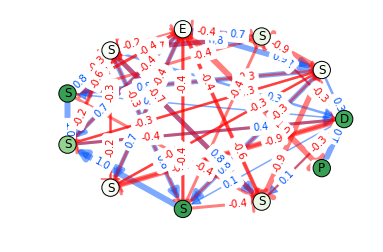

0.1353352832366127


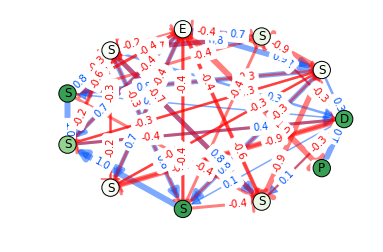

0.1353352832366127


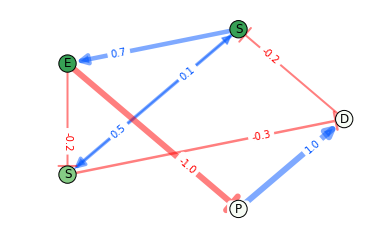

0.1347950233437982


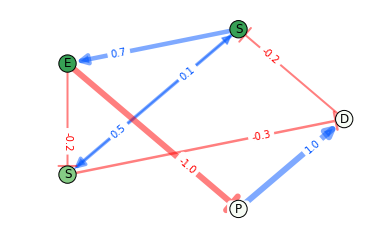

0.1347950233437982


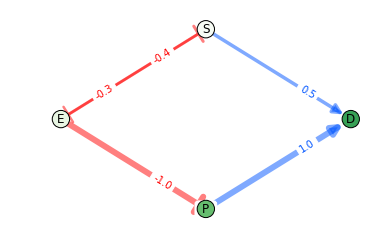

0.14653704598562206


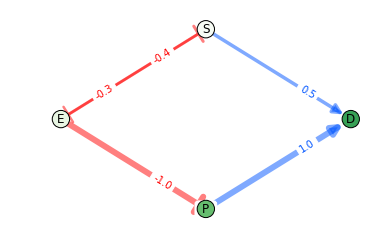

0.14653704598562206


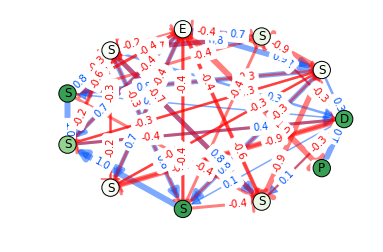

0.1353352832366127


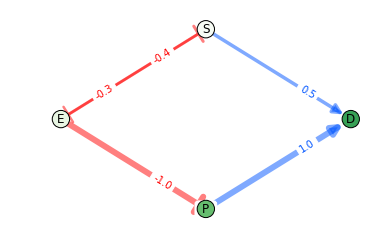

0.14653704598562206


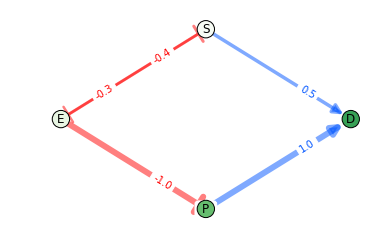

0.14653704598562206


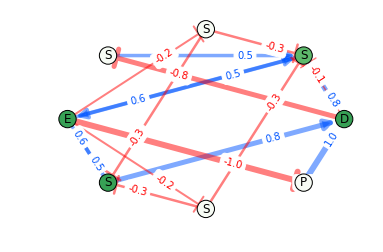

0.1347950233437982


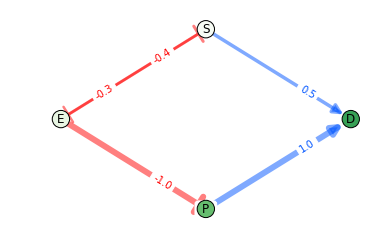

0.14653704598562206


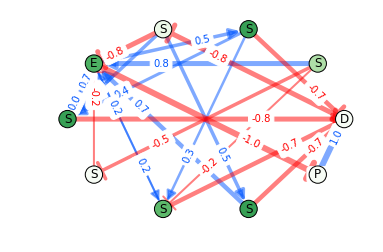

0.19301459641847935


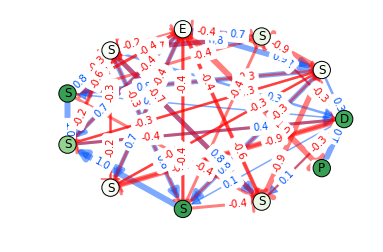

0.1353352832366127


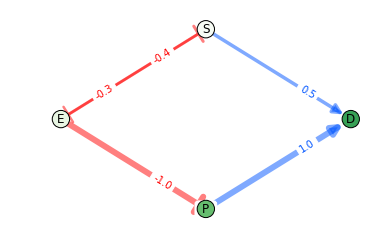

0.14653704598562206


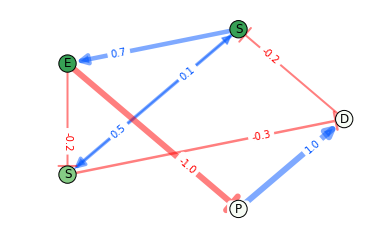

0.1347950233437982


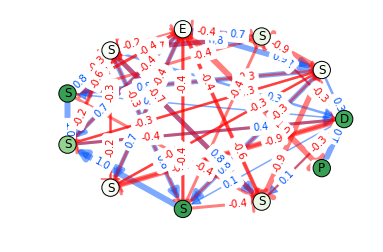

0.1353352832366127


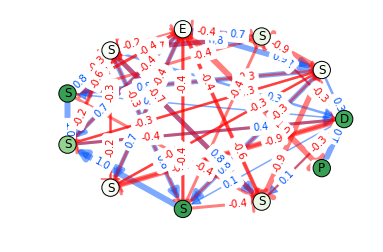

0.1353352832366127


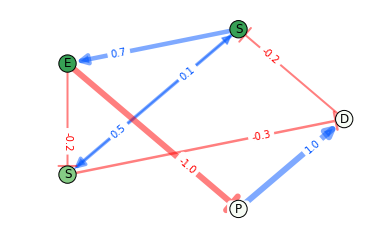

0.1347950233437982


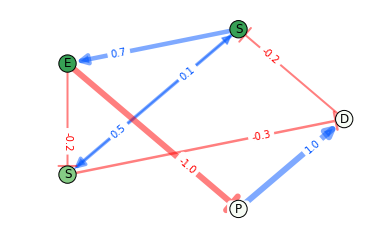

0.1347950233437982


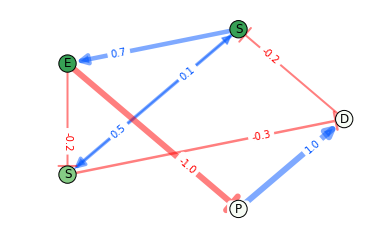

0.1347950233437982


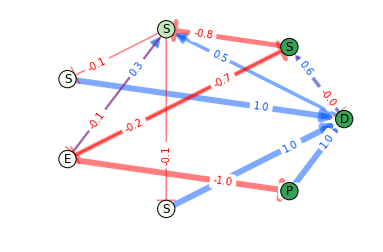

0.1353352832366127


In [16]:
for host in population1.hosts:
    host.visualize()
    print(host.fitness_host)

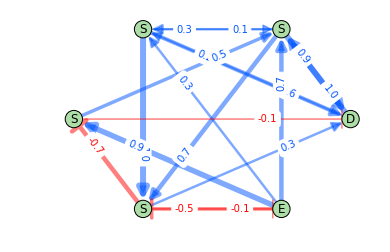

Pre-active:  1.0627054273712575e-22
Post-active:  1.813918669091256e-44


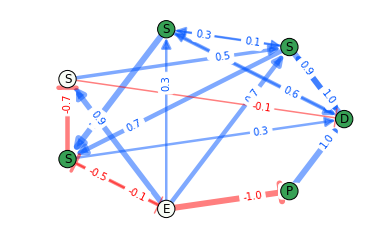

0.006737946999085467
{'active': 1.0, 'label': 'P', 'area': 1.0, 'v': 5}


In [58]:
test_host = Host()
test_host.visualize()
test_host.evolve()
test_host.visualize()
print(test_host.fitness_host)
print(test_host.network.nodes['P'])


In [243]:

population_size = 20
threshold = 0.1

hosts = [Host() for _ in range(population_size)]
#print(len(hosts))

for _ in range(5):
    fitness_vector = np.zeros(population_size)
    for i,host in enumerate(hosts):
        host.evolve(parasite_seed=10)
        fitness_vector[i] = host.fitness_host
        print(fitness_vector)


    print('Mean fitness: ',np.mean(fitness_vector))

    fitness_vector = np.array([x for x in fitness_vector if  x > threshold])

    cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))

    hosts = [hosts[i].reproduce() for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size))]
#print(cumulative_fitness.shape)
#print(cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size)).shape)

# for _ in range(5):
#     next_gen = [hosts[i].reproduce() for i in cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size))]

#     for i,host in enumerate(next_gen):
#         host.evolve(parasite_seed=10, verbose=0)
#         print(fitness_vector)
#         fitness_vector[i] = host.fitness_host
#     print('Mean fitness: ',np.mean(fitness_vector))

#     fitness_vector = np.array([x for x in fitness_vector if  x > threshold])
    
#     cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))


#plt.show()
# signalers = [n for n in self.architecture.nodes if n not in ['D','E']]
# np.random.choice(signalers)

[0.13479502 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.13479503 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.13479503 0.13479502 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.14594251 0.13479503 0.13479502 0.13625199 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     

[0.13479502 0.19797216 0.13479502 0.13533528 0.13625199 0.13479502
 0.13479502 0.13479502 0.14594251 0.10518666 0.13533528 0.13479502
 0.17335739 0.21258831 0.19797216 0.10518666 0.18744229 0.25158348
 0.10518666 0.17335739]
Mean fitness:  0.15357341888992068
[0.13479502 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.21258831 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.21258831 0.10518666 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.21258831 0.10518666 0.13479502 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.     

[0.13479502 0.18744229 0.19797216 0.17335739 0.13625199 0.13625199
 0.19797216 0.13479502 0.21258831 0.21258831 0.17335739 0.13479502
 0.17335739 0.13479502 0.13479502 0.21258831 0.10518666 0.19797216
 0.21258831 0.        ]
[0.13479502 0.18744229 0.19797216 0.17335739 0.13625199 0.13625199
 0.19797216 0.13479502 0.21258831 0.21258831 0.17335739 0.13479502
 0.17335739 0.13479502 0.13479502 0.21258831 0.10518666 0.19797216
 0.21258831 0.13479502]
Mean fitness:  0.16691224890370063
[0.13479502 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.17335739 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.13479502 0.17335739 0.21258831 0.         0.         0.
 0.         0.         0.         0.         0.       

In [161]:
print(fitness_vector)
print(normalize(fitness_vector.reshape(-1,1), 'l1', 0))
cumulative_fitness = np.cumsum(normalize(fitness_vector.reshape(-1,1), axis=0, norm='l1'))
print(cumulative_fitness)
print(cumulative_fitness.searchsorted(np.random.uniform(0, 1, population_size)))


#plt.hist(fitness_vector)
#plt.plot(fitness_vector/15)






#np.random.seed(np.random.randint(0,20))

#plt.hist(cumulative_fitness.searchsorted(np.random.uniform(0, 1, 10000)), density=True)

#plt.show()

[0.13533528 0.13533528 0.18300694 0.13533528 0.187234   0.13474112
 0.17438905 0.13291844 0.11143536 0.15180075]
[[0.09134823]
 [0.09134823]
 [0.12352551]
 [0.09134823]
 [0.12637868]
 [0.09094719]
 [0.11770863]
 [0.08971691]
 [0.07521633]
 [0.10246205]]
[0.09134823 0.18269646 0.30622198 0.39757021 0.52394889 0.61489608
 0.73260471 0.82232162 0.89753795 1.        ]
[4 3 6 3 0 8 7 8 4 5]


In [231]:
test = Host()
test.evolve()

Nodes: ['D', 0, 1, 2, 3, 'E', 'P']
Signalers:  [0, 1, 2, 3]
0


Original


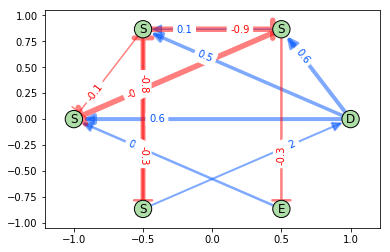

Post-infection


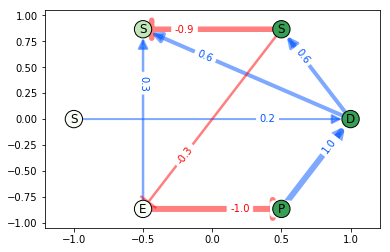

Architecture


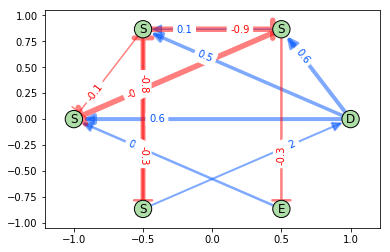

0.1353352832366127
Original


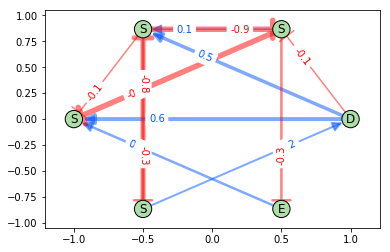

Post-infection


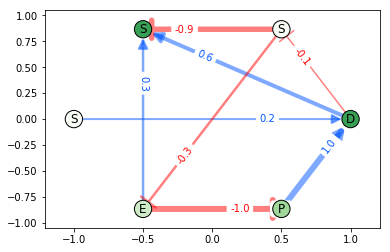

Architecture


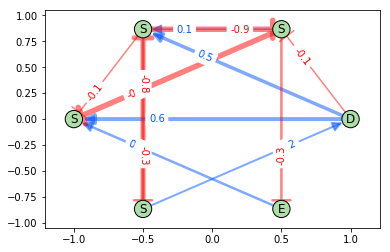

0.16038251467352832


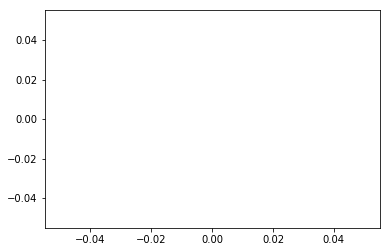

2.446741819381714


In [34]:
#n_nodes = 6

child = Host()


fitness_record = []
start = time()
for _ in range(2):
    print('Original')
    child.visualize()


    child.evolve(parasite_seed=10)
    print('Post-infection')
    child.visualize()
    print('Architecture')
    child.visualize_architecture()
    np.random.seed()
    #fitness_record.append(child.fitness_host)
    if child.fitness_host > 1e-4:
        print(child.fitness_host)
        child = child.reproduce(p_mutation=0.9,verbose=0)
        #child.visualize()
    else:
        'The host died without reproducing'

#child.visualize()

plt.plot(fitness_record)
plt.show()
print(time() - start)



# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()
# child = child.reproduce(p_mutation=0.9,verbose=1)
# child.visualize()




#list(net.network.nodes).remove(['D','E'])




#print([type(d['weight']) for u,v,d in net.network.edges(data=True)])



#np.random.choice(net.network.edges())

# edge_index = np.random.randint(0,len(net.network.edges()))
# edge_to_alter = list(net.network.edges())[edge_index]
# net.network.edges[edge_to_alter]['weight'] = np.random.uniform(-1.0,1.0)

#print('...',edge_to_alter)

#for e in net.network.edges():
#    print(net.network.edges[e])



#print(edge_to_remove)
#net.visualize()


# hfitness = []
# pfitness = []

# for _ in range(40):
#     net = Host()

#     net.evolve(seed=10, verbose=0)
# #    net.visualize()
#     hfitness.append(net.fitness_host)
#     pfitness.append(net.fitness_parasite)
#     if net.fitness_parasite > 1: print(net.fitness_parasite)
    
#     if _ % 10 == 0: print((_+10),'% done')

# sns.distplot(hfitness)
# sns.distplot(pfitness)
# plt.xscale('log')
# plt.show()

# print('CI Host: ', np.percentile(hfitness, [2.5,97.5]))
# print('CI Parasite: ', np.percentile(pfitness, [2.5,97.5]))


    #print(net.fitness_parasite)

# for _ in range(1000):
#     net.update()
# net.visualize()

# net.infect()

# print(net.network.nodes['P'])


# net.visualize()

# for _ in range(100):
#     net.update()
# net.visualize()
# print(net.network.nodes)

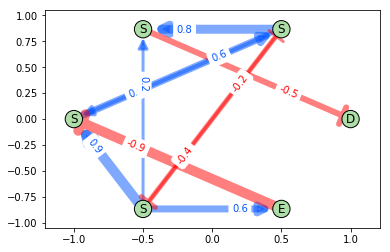

(0.7836720817875342,
 0.30354824786580803,
 -0.38316354575187517,
 -0.46276880384768737,
 0.6085317310864882,
 -0.18043477076739767,
 0.15955452814399318,
 0.8758469587631248,
 0.6486390425279196,
 -0.8594355079729348)

In [1251]:
n_nodes = 6
host_network = nx.binomial_graph(directed=True, n=n_nodes,p=0.5)

#### initialize


for node in host_network.nodes:
    host_network.nodes[node]['active'] = 0.5


for u,v,e in host_network.edges(data=True):
    e['weight'] = np.random.uniform(-1,1)

host_network.remove_edges_from([(0,n_nodes-1),(n_nodes-1,0)])




#### visualize

edges,weights = zip(*nx.get_edge_attributes(host_network,'weight').items())

activating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]
positive_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w > 0]

deactivating = [e for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]
negative_weights = [round(w,1) for e,w in nx.get_edge_attributes(host_network,'weight').items() if w < 0]

active_ratios = list(nx.get_node_attributes(host_network,'active').values())

pos = nx.shell_layout(host_network)

graph_nodes = nx.draw_networkx_nodes(host_network, node_size=300, pos=pos, alpha=1, 
                       node_color= [a for a in active_ratios],
                                    cmap='Greens', vmin=0, vmax=1.5)  

graph_act_edges =nx.draw_networkx_edges(host_network, edgelist=activating,
                       pos=pos, width=[10*abs(w)+1 for w in positive_weights], arrowsize=20, edge_color= '#0055FF',
                        #edge_cmap= plt.cm.Blues, vmax=1, edge_color=positive_weights,
                        alpha=1)

graph_deact_edges = nx.draw_networkx_edges(host_network, edgelist=deactivating,
                       pos=pos, width=[10*abs(w)+1 for w in negative_weights], arrowsize=30, edge_color = '#FF0000',
                        #edge_cmap= plt.cm.Reds, edge_color=negative_weights,
                        alpha=0.6, arrowstyle=matplotlib.patches.ArrowStyle("|-|",widthA=0, widthB=0.3))

letters = ['D']+(host_network.number_of_nodes()-2)*['S']+['E']
labels = dict(zip(host_network.nodes,letters))

nx.draw_networkx_labels(host_network, pos=pos, 
                       labels = labels)
nx.draw_networkx_edge_labels(host_network, font_color='#0055FF', label_pos=0.3, pos=pos, edge_labels=dict(zip(activating,positive_weights)))
nx.draw_networkx_edge_labels(host_network, font_color='#FF0000', label_pos = 0.3, pos=pos, edge_labels=dict(zip(deactivating,negative_weights)))


#ax = plt.gca() # to get the current axis

graph_nodes.set_edgecolor('k')

for e in graph_act_edges+graph_deact_edges:
    e.set_alpha(0.5)

plt.show()

weights

In [8]:
dict(list(zip(range(n_nodes), ['D']+list(range(n_nodes-2))+['E'])))

NameError: name 'n_nodes' is not defined

TypeError: Cannot cast array from dtype('float64') to dtype('int64') according to the rule 'safe'

In [1192]:
np.array(['P',2])
#np.random.sample(('P',2))
sorted(('P',2), key=lambda k: np.random.random())

['P', 2]

In [1204]:
net.network.nodes['2']

KeyError: '2'

In [1216]:
int('2')

2

In [1370]:
5e-3

0.005

In [282]:
fitsum = np.array([float(i) for i in '''0.00875713 0.01751427 0.02623806 0.03499519 0.04440789 0.05313007
 0.06188720 0.07310463 0.08382567 0.09116545 0.09949823 0.10822040
 0.11943783 0.12819496 0.13695210 0.14567445 0.15439662 0.16311880
 0.18965121 0.19837338 0.20713473 0.21585691 0.22457908 0.23374919
 0.24247137 0.25119354 0.25991397 0.27113140 0.28296466 0.29168684
 0.30044397 0.30949211 0.32511026 0.33383499 0.34627650 0.35501235
 0.36376948 0.37299702 0.38171919 0.39044136 0.39916354 0.41098009
 0.41851272 0.42723489 0.43595707 0.44467924 0.45343638 0.46219351
 0.47095064 0.50262711 0.51341704 0.52355849 0.53231562 0.54107275
 0.58398120 0.59270337 0.61851905 0.62748883 0.63621101 0.64496814
 0.65372527 0.66244745 0.67120458 0.67904982 0.69122026 0.71532519
 0.72408232 0.73283945 0.74307948 0.75180165 0.76055878 0.76931592
 0.77803809 0.79063231 0.79935448 0.80805205 0.81677423 0.82549640
 0.83421858 0.85766870 0.86639088 0.87431131 0.88209080 0.89426117
 0.91051352 0.92136841 0.93136258 0.94011971 0.95010510 0.95886223
 0.96761914 0.97634131 0.99136729 1.'''.split(r' ')])

In [303]:
np.any(fitsum.searchsorted(np.random.uniform(0, 1, 100000000)) > 93)

False

In [60]:
[n for n in host.architecture.nodes if n not in ['D','E']]

[1, 2, 3, 4, 5]

In [64]:
list(host.architecture.edges.data())

[('D', 2, {'weight': 0.5174852774024312}),
 ('D', 1, {'weight': 0.5501181354046347}),
 ('D', 5, {'weight': 0.5174852774024312}),
 (1, 'D', {'weight': -0.021080925402781725}),
 (1, 2, {'weight': -0.760631292781746}),
 (1, 'E', {'weight': -0.23624219157982163}),
 (1, 5, {'weight': -0.760631292781746}),
 (2, 3, {'weight': -0.08093515426928377}),
 (2, 'E', {'weight': -0.13649494310789367}),
 (2, 4, {'weight': -0.08093515426928377}),
 (3, 'D', {'weight': 0.9551585314483317}),
 ('E', 1, {'weight': -0.7258797347981816}),
 ('E', 2, {'weight': 0.30263802053204825}),
 ('E', 5, {'weight': 0.30263802053204825}),
 (4, 'D', {'weight': 0.9551585314483317}),
 (5, 3, {'weight': -0.08093515426928377}),
 (5, 'E', {'weight': -0.13649494310789367}),
 (5, 4, {'weight': -0.08093515426928377})]

In [15]:
print(list(zip(itertools.cycle([2]),host.architecture.nodes)))
print([(u,v) for u,v,d in host.architecture.edges(data=True) if u == 2 or v == 2])

[(2, 'D'), (2, 0), (2, 1), (2, 2), (2, 3), (2, 'E')]
[('D', 2), (0, 2), (2, 0), (2, 1), ('E', 2)]


In [13]:
list(zip(itertools.cycle(['v']),['v','a']))

[('v', 'v'), ('v', 'a')]

In [6]:
host = Host()

In [7]:
host.architecture

In [23]:
list(itertools.product(host.architecture.nodes, r=2, ))

TypeError: 'r' is an invalid keyword argument for this function

In [50]:
print(list(zip(itertools.cycle([2]),host.architecture.nodes)))

[(2, 'D'), (2, 0), (2, 1), (2, 2), (2, 3), (2, 'E')]


In [53]:
[x for x in itertools.permutations([1,2,3], 2)]

[(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]

In [43]:
test_set.pop()

(2, 'D')

In [54]:
[(u,v) for u,v,d in host.architecture.edges(data=True) if u == 2 or v == 2]

[('D', 2), (0, 2), (2, 0), (2, 1), ('E', 2)]

In [55]:
host.n_signalers

4

In [57]:
len(host.network.nodes)

6

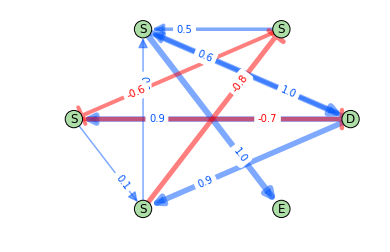

{'active': 0.5, 'label': 'P', 'area': 0.5, 'v': 5}


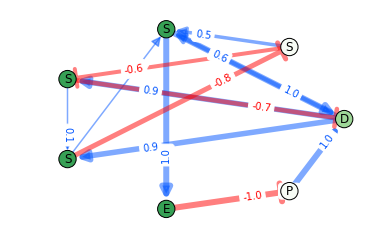

In [132]:
host = Host(verbose=1)
host.visualize()
#host.infect()
host.evolve()
host.visualize()

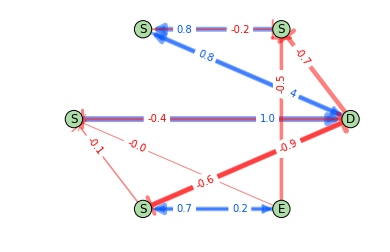

In [116]:
host.reproduce().visualize()

In [73]:
signaler = 2

list(set([p for p in itertools.permutations(host.new_architecture.nodes, signaler) if p[0] == signaler or p[1] == signaler]) - \
                                set([(u,v) for u,v,d in host.new_architecture.edges(data=True) if u == signaler or v == signaler]))

[(3, 2), (2, 'D'), (2, 1), (2, 3), ('E', 2)]